## Import Libs and Settings


In [1]:
import os
from os import listdir
from collections import Counter
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import tensorflow as tf
import missingno as msno
import math
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# check the system font
import matplotlib.font_manager as font_manager
font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

# add the font wanted
font_dir = ['/content/drive/MyDrive/Colab_Notebooks/EarlySepsisPrediction/Latin-Modern-Roman']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

In [4]:
# Set font family globally
plt.rcParams['font.family'] = 'Latin Modern Roman'
print(plt.rcParams['font.family'])

['Latin Modern Roman']


## Load training and test data

Load the training/test data from the `processed_data`

Training: sepsis = 55 while non_sepsis = 55

Test: sepsis = 56 while non_sepsis = 56

In [20]:
path_processed_sepsis = '/content/drive/MyDrive/Colab_Notebooks/MIMIC/Results/neonates/processed_sepsis/'
data_processed_sepsis = sorted(os.listdir(path_processed_sepsis))

path_processed_non_sepsis = '/content/drive/MyDrive/Colab_Notebooks/MIMIC/Results/neonates/processed_non_sepsis/'
data_processed_non_sepsis = sorted(os.listdir(path_processed_non_sepsis))

path_train = '/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/data_train/'
path_test = '/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/data_test/'

In [28]:
# folder for training data
for neonate in data_processed_sepsis[:56]:
  df0 = pd.read_csv(path_processed_sepsis+neonate)
  df0.to_csv(path_train+neonate, index= False)

for neonate in data_processed_non_sepsis[1000:1056]:  #random
  df0 = pd.read_csv(path_processed_non_sepsis+neonate)
  df0.to_csv(path_train+neonate, index = False)

# folder for test data
for neonate in data_processed_sepsis[56:]:
  df0 = pd.read_csv(path_processed_sepsis+neonate)
  df0.to_csv(path_test+neonate, index= False)

for neonate in data_processed_non_sepsis[2000:2057]:  #random
  df0 = pd.read_csv(path_processed_non_sepsis+neonate)
  df0.to_csv(path_test+neonate, index = False)

In [29]:
print('Number of training data:', len(sorted(os.listdir(path_train))))
print('Number of test data:', len(sorted(os.listdir(path_test))))

Number of training data: 112
Number of test data: 114


In [32]:
data_train = sorted(os.listdir(path_train))
data_test = sorted(os.listdir(path_test))

## Process Data

### Help functions

In [30]:
# function to add new columns containing as mang features as possible
def new_features(df):
  #attributes that are worked on: HR, Resp, Temp

  #copy df
  df_dev = df.copy()

  # three standard deviation for HR -> HR_dev_1, HR_dev_2, HR_dev_3
  hr = df_dev['HR']
  hr_len = len(hr)
  hr_dev_1 = hr.copy()
  hr_dev_2 = hr.copy()
  hr_dev_3 = hr.copy()
  for i, j in hr_dev_1.iteritems():
    if i > hr_len - 5:
      hr_dev_1[i] = hr[i:hr_len].std()
    else:
      hr_dev_1[i] = hr[i:i+5].std()
  hr_dev_1[hr_len-1] = hr_dev_1[hr_len-2]
  df_dev['HR_dev_1'] = hr_dev_1

  for i, j in hr_dev_2.iteritems():
    if i > hr_len - 10:
      hr_dev_2[i] = hr[i:hr_len].std()
    else:
      hr_dev_2[i] = hr[i:i+10].std()
  hr_dev_2[hr_len-1] = hr_dev_2[hr_len-2]
  df_dev['HR_dev_2'] = hr_dev_2

  for i, j in hr_dev_3.iteritems():
    if i > hr_len - 20:
      hr_dev_3[i] = hr[i:hr_len].std()
    else:
      hr_dev_3[i] = hr[i:i+20].std()
  hr_dev_3[hr_len-1] = hr_dev_3[hr_len-2]
  df_dev['HR_dev_3'] = hr_dev_3


  # three standard deviation for Resp -> Resp_dev_1, Resp_dev_2, Resp_dev_3
  rr = df_dev['RR']
  rr_len = len(rr)
  rr_dev_1 = rr.copy()
  rr_dev_2 = rr.copy()
  rr_dev_3 = rr.copy()
  for i, j in rr_dev_1.iteritems():
    if i < rr_len -5:
      rr_dev_1[i] = rr[i:rr_len].std()
    else:
      rr_dev_1[i] = rr[i:i+5].std()
  rr_dev_1[rr_len-1] = rr_dev_1[rr_len-2]
  df_dev['Resp_dev_1'] = rr_dev_1

  for i, j in rr_dev_2.iteritems():
    if i < rr_len -10:
      rr_dev_2[i] = rr[i:rr_len].std()
    else:
      rr_dev_2[i] = rr[i:i+10].std()
  rr_dev_2[rr_len-1] = rr_dev_2[rr_len-2]
  df_dev['Resp_dev_2'] = rr_dev_2

  for i, j in rr_dev_3.iteritems():
    if i < rr_len -20:
      rr_dev_3[i] = rr[i:rr_len].std()
    else:
      rr_dev_3[i] = rr[i:i+20].std()
  rr_dev_3[rr_len-1] = rr_dev_3[rr_len-2]
  df_dev['Resp_dev_3'] = rr_dev_3

  # three standard deviation for Temp -> Temp_dev_1, Temp_dev_2, Temp_dev_3
  t = df_dev['Temp']
  t_len = len(t)
  t_dev_1 = t.copy()
  t_dev_2 = t.copy()
  t_dev_3 = t.copy()
  for i, j in t_dev_1.iteritems():
    if i < t_len - 5:
      t_dev_1[i] = t[i:t_len].std()
    else:
      t_dev_1[i] = t[i:i+5].std()
  t_dev_1[t_len-1] = t_dev_1[t_len-2]
  df_dev['Temp_dev_1'] = t_dev_1

  for i, j in t_dev_2.iteritems():
    if i < t_len - 10:
      t_dev_2[i] = t[i:t_len].std()
    else:
      t_dev_2[i] = t[i:i+10].std()
  t_dev_2[t_len-1] = t_dev_2[t_len-2]
  df_dev['Temp_dev_2'] = t_dev_2

  for i, j in t_dev_3.iteritems():
    if i < t_len - 20:
      t_dev_3[i] = t[i:t_len].std()
    else:
      t_dev_3[i] = t[i:i+20].std()
  t_dev_3[t_len-1] = t_dev_3[t_len-2]
  df_dev['Temp_dev_3'] = t_dev_3

  # features for indicating bradycardia and tachycardia
  brady = hr.copy()
  tachy = hr.copy()
  for i,j in brady.iteritems():
    if hr[i] < 100:
      brady[i] = 1
    else:
      brady[i] = 0
    if hr[i] > 220:
      tachy[i] = 1
    else:
      tachy[i] = 0
  df_dev['Bradycardia'] = brady
  df_dev['Tachycardia'] = tachy

  # features for indicating Hypothermia, Hyperthermia(Fever) and Hyperpyrexia
  hypothermia = t.copy()
  fever = t.copy()
  hyperpyrexia = t.copy()
  for i,j in t.iteritems():
    if t[i] <97.7:
      hypothermia[i] = 1
    else:
      hypothermia[i] = 0
    if t[i] >100.4:
      fever[i] = 1
    else:
      fever[i] = 0
    if t[i] >104:
      hyperpyrexia[i] = 1
    else:
      hyperpyrexia[i] = 0
  df_dev['Hypothermia'] = hypothermia
  df_dev['Fever'] = fever
  df_dev['Hyperpyrexia'] = hyperpyrexia

  return df_dev


In [31]:
# function to fill missing values
def impute_missing_vals(df, attributes):

    """
    function that imputes missing values.
    
    @param df: dataframe that has missing values to be
               imputed
           attributes: list of String, attributes of dataframe
    @return df_clean: dataframe without missing values

    """
    
    """
    fill missing values by the closest values first
    ffill to fill missing values in the tail
    bfill to fill missing values in the head
    """
    # copy df
    df_clean = df.copy()
    for att in attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0)
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill()
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both')
            df_clean[att] = df_clean[att].ffill().bfill()
    
    return df_clean

### Process data

Train data

In [34]:
X_train = []
y_train = []
total_X_data = pd.DataFrame(columns=['gender', 'SBP', 'DBP', 'MAP',
       'Temp', 'HR', 'RR', 'BaseExcess', 'FiO2', 'SaO2', 'PCO2', 'PH',
       'Calcium', 'Sodium', 'Potassium', 'Creatinine', 'Chloride', 'Glucose',
       'WBC', 'BUN', 'PTT', 'Platelet'])
total_y_data = pd.DataFrame(columns=['sepsis'])

for i in data_train:
    print(i)
    data = pd.read_csv(path_train+i,sep = ',')
    data.drop(['subject_id','time'], axis = 1,inplace = True)

    # drop the features unwanted
    # data.drop(['EtCO2','Fibrinogen', 'Unit1', 'Unit2', 'BaseExcess', 'DBP', 'Hct', 'Hgb', 'PTT', 'WBC', 'pH','HCO3','FiO2', 'PaCO2', 'Platelets', 'Magnesium',  'Phosphate',  'Potassium', 'Bilirubin_total',  'TroponinI','SaO2', 'AST','BUN', 'Alkalinephos', 'Bilirubin_direct','Glucose','Lactate', 'Calcium',  'Chloride', 'Creatinine' ],axis = 1,inplace = True)
    
    # drop the row that has more than 40% for missing data -> 
    # rows that have less than 4 feature values will be dropped
    # data.dropna(thresh=data.shape[1]*0.40,how='all',inplace = True)
    
    # to label whether this patient has sepsis or not,
    # leave only one label for one .psv file (patient)
    La_1 = data['sepsis'].sum()
    if La_1:
        y_train.append(1)
    else:
        y_train.append(0)
    data.drop(['sepsis'],axis = 1,inplace = True)
    # fill the NaN point in the data, using median() value
    # if one feature happens to have all NaN -> fill with 0
    attr = data.columns
    data = impute_missing_vals(data, attr)
    # will  be adjusted to use forward-filling to compare the results
    
    empty_row = {'gender':data['gender'][0], 'SBP':0, 'DBP':0, 'MAP':0,
       'Temp':0, 'HR':0, 'RR':0, 'BaseExcess':0, 'FiO2':0, 'SaO2':0, 'PCO2':0, 'PH':0,
       'Calcium':0, 'Sodium':0, 'Potassium':0, 'Creatinine':0, 'Chloride':0, 'Glucose':0,
       'WBC':0, 'BUN':0, 'PTT':0, 'Platelet':0}
    # unify the length of the input data
    if len(data) < 40:
        Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(data))])
        data = pd.concat([Pad, data]).reset_index(drop = True)
        # data = data.reindex(range(40),fill_value = 0) # use this line to padd zeros at the data end
    elif len(data) > 40:
        data = data[len(data)-40::1]

    # add the engineered features
    data = data.reset_index(drop = True)
    data = new_features(data)
    # print(data)

    total_X_data = pd.concat([total_X_data, data]).reset_index(drop = True)
    data = data.values # from DataFrame to numpy array
    X_train.append(data)
    print('X_train: ' , len(X_train))
    print('y_train: ' , len(y_train))

10055.csv
X_train:  1
y_train:  1
10318.csv
X_train:  2
y_train:  2
10576.csv
X_train:  3
y_train:  3
10826.csv
X_train:  4
y_train:  4
10885.csv
X_train:  5
y_train:  5
11024.csv
X_train:  6
y_train:  6
11367.csv
X_train:  7
y_train:  7
1154.csv
X_train:  8
y_train:  8
11653.csv
X_train:  9
y_train:  9
11690.csv
X_train:  10
y_train:  10
12062.csv
X_train:  11
y_train:  11
12652.csv
X_train:  12
y_train:  12
12680.csv
X_train:  13
y_train:  13
12836.csv
X_train:  14
y_train:  14
12950.csv
X_train:  15
y_train:  15
13297.csv
X_train:  16
y_train:  16
13571.csv
X_train:  17
y_train:  17
13786.csv
X_train:  18
y_train:  18
14273.csv
X_train:  19
y_train:  19
14479.csv
X_train:  20
y_train:  20
1456.csv
X_train:  21
y_train:  21
15032.csv
X_train:  22
y_train:  22
1504.csv
X_train:  23
y_train:  23
1520.csv
X_train:  24
y_train:  24
15865.csv
X_train:  25
y_train:  25
15989.csv
X_train:  26
y_train:  26
16108.csv
X_train:  27
y_train:  27
16244.csv
X_train:  28
y_train:  28
16250.csv
X_tr

In [36]:
print(np.any(pd.isnull(X_train)))
print(np.any(pd.isnull(y_train)))

False
False


In [37]:
import pickle
with open("/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/X_train.pickle", "wb") as fp:   #Pickling
  pickle.dump(X_train, fp)
with open("/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/y_train.pickle", "wb") as fp:   #Pickling
  pickle.dump(y_train, fp)

total_X_data.to_pickle("/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/total_X_data.pickle")

In [39]:
X_train, y_train = np.array(X_train) , np.array(y_train)
X_train[X_train == 'F'] = 0
X_train[X_train == 'M'] = 1
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
print(X_train.shape)
print(y_train.shape)

(112, 40, 36)
(112,)


Test data

In [35]:
X_test = []
y_test = []
total_X_test_data = pd.DataFrame(columns=['gender', 'SBP', 'DBP', 'MAP',
       'Temp', 'HR', 'RR', 'BaseExcess', 'FiO2', 'SaO2', 'PCO2', 'PH',
       'Calcium', 'Sodium', 'Potassium', 'Creatinine', 'Chloride', 'Glucose',
       'WBC', 'BUN', 'PTT', 'Platelet'])
total_y_test_data = pd.DataFrame(columns=['sepsis'])

for i in data_test:
    print(i)
    data = pd.read_csv(path_test+i,sep = ',')
    data.drop(['subject_id','time'], axis = 1,inplace = True)

    # drop the features unwanted
    # data.drop(['EtCO2','Fibrinogen', 'Unit1', 'Unit2', 'BaseExcess', 'DBP', 'Hct', 'Hgb', 'PTT', 'WBC', 'pH','HCO3','FiO2', 'PaCO2', 'Platelets', 'Magnesium',  'Phosphate',  'Potassium', 'Bilirubin_total',  'TroponinI','SaO2', 'AST','BUN', 'Alkalinephos', 'Bilirubin_direct','Glucose','Lactate', 'Calcium',  'Chloride', 'Creatinine' ],axis = 1,inplace = True)
    
    # drop the row that has more than 40% for missing data -> 
    # rows that have less than 4 feature values will be dropped
    # data.dropna(thresh=data.shape[1]*0.40,how='all',inplace = True)
    
    # to label whether this patient has sepsis or not,
    # leave only one label for one .psv file (patient)
    La_1 = data['sepsis'].sum()
    if La_1:
        y_test.append(1)
    else:
        y_test.append(0)
    data.drop(['sepsis'],axis = 1,inplace = True)
    # fill the NaN point in the data, using median() value
    # if one feature happens to have all NaN -> fill with 0
    attr = data.columns
    data = impute_missing_vals(data, attr)
    # will  be adjusted to use forward-filling to compare the results
    
    empty_row = {'gender':data['gender'][0], 'SBP':0, 'DBP':0, 'MAP':0,
       'Temp':0, 'HR':0, 'RR':0, 'BaseExcess':0, 'FiO2':0, 'SaO2':0, 'PCO2':0, 'PH':0,
       'Calcium':0, 'Sodium':0, 'Potassium':0, 'Creatinine':0, 'Chloride':0, 'Glucose':0,
       'WBC':0, 'BUN':0, 'PTT':0, 'Platelet':0}
    # unify the length of the input data
    if len(data) < 40:
        Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(data))])
        data = pd.concat([Pad, data]).reset_index(drop = True)
        # data = data.reindex(range(40),fill_value = 0) # use this line to padd zeros at the data end
    elif len(data) > 40:
        data = data[len(data)-40::1]

    # add the engineered features
    data = data.reset_index(drop = True)
    data = new_features(data)
    # print(data)

    total_X_test_data = pd.concat([total_X_test_data, data]).reset_index(drop = True)
    data = data.values # from DataFrame to numpy array
    X_test.append(data)
    print('X_test: ' , len(X_test))
    print('y_test: ' , len(y_test))

24889.csv
X_test:  1
y_test:  1
25252.csv
X_test:  2
y_test:  2
25327.csv
X_test:  3
y_test:  3
25387.csv
X_test:  4
y_test:  4
25396.csv
X_test:  5
y_test:  5
25397.csv
X_test:  6
y_test:  6
25460.csv
X_test:  7
y_test:  7
25625.csv
X_test:  8
y_test:  8
25714.csv
X_test:  9
y_test:  9
25752.csv
X_test:  10
y_test:  10
25789.csv
X_test:  11
y_test:  11
26168.csv
X_test:  12
y_test:  12
2624.csv
X_test:  13
y_test:  13
26403.csv
X_test:  14
y_test:  14
26430.csv
X_test:  15
y_test:  15
26436.csv
X_test:  16
y_test:  16
26439.csv
X_test:  17
y_test:  17
26444.csv
X_test:  18
y_test:  18
26448.csv
X_test:  19
y_test:  19
26453.csv
X_test:  20
y_test:  20
26460.csv
X_test:  21
y_test:  21
26464.csv
X_test:  22
y_test:  22
26478.csv
X_test:  23
y_test:  23
26512.csv
X_test:  24
y_test:  24
26531.csv
X_test:  25
y_test:  25
26540.csv
X_test:  26
y_test:  26
26541.csv
X_test:  27
y_test:  27
26546.csv
X_test:  28
y_test:  28
26547.csv
X_test:  29
y_test:  29
26559.csv
X_test:  30
y_test:  30

In [40]:
print(np.any(pd.isnull(X_test)))
print(np.any(pd.isnull(y_test)))

False
False


In [41]:
import pickle
with open("/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/X_test.pickle", "wb") as fp:   #Pickling
  pickle.dump(X_test, fp)
with open("/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/y_test.pickle", "wb") as fp:   #Pickling
  pickle.dump(y_test, fp)

total_X_test_data.to_pickle("/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_TL/total_X_test_data.pickle")

In [42]:
X_test, y_test = np.array(X_test) , np.array(y_test)
X_test[X_test == 'F'] = 0
X_test[X_test == 'M'] = 1
X_test= X_test.astype('float32')
y_test = y_test.astype('float32')
print(X_test.shape)
print(y_test.shape)

(114, 40, 36)
(114,)


## Re-train model

In [44]:
base_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/MIMIC/artificial_neonates/models/model_LSTM/model.h5')

# params for the LSTM layers shouldn't be trainable
base_model.layers[0].trainable = False
base_model.layers[1].trainable = False
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           84480     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 257,409
Trainable params: 41,345
Non-train

Compile the model

In [50]:
base_learning_rate = 0.0001

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = base_model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_split=(3/17), shuffle=True)

Epoch 1/40
3/3 [==============================] - 5s 539ms/step - loss: 0.4175 - accuracy: 0.7826 - val_loss: 0.8439 - val_accuracy: 0.6500
Epoch 2/40
3/3 [==============================] - 0s 76ms/step - loss: 0.4135 - accuracy: 0.7935 - val_loss: 0.8446 - val_accuracy: 0.6500
Epoch 3/40
3/3 [==============================] - 0s 73ms/step - loss: 0.4144 - accuracy: 0.8043 - val_loss: 0.8668 - val_accuracy: 0.6000
Epoch 4/40
3/3 [==============================] - 0s 75ms/step - loss: 0.4114 - accuracy: 0.8152 - val_loss: 0.8589 - val_accuracy: 0.6000
Epoch 5/40
3/3 [==============================] - 0s 77ms/step - loss: 0.4110 - accuracy: 0.7826 - val_loss: 0.8404 - val_accuracy: 0.6500
Epoch 6/40
3/3 [==============================] - 0s 73ms/step - loss: 0.4088 - accuracy: 0.7935 - val_loss: 0.8394 - val_accuracy: 0.6500
Epoch 7/40
3/3 [==============================] - 0s 83ms/step - loss: 0.4090 - accuracy: 0.7935 - val_loss: 0.8495 - val_accuracy: 0.6500
Epoch 8/40
3/3 [==========

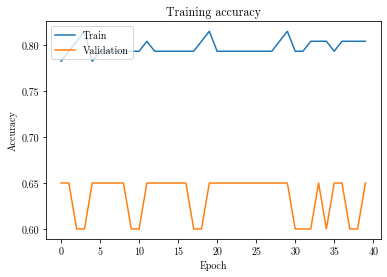

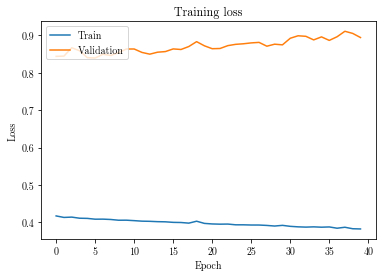

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('training_acc.png')
# plt.savefig('training_acc.eps')
plt.show()
# loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('training_loss.png')
# plt.savefig('training_loss.eps')
plt.show()

In [52]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           84480     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 257,409
Trainable params: 41,345
Non-train

## Test re-trained model

In [53]:
# predict on test
y_pred = base_model.predict(X_test)

# converting the continuous values which are outputs from the sigmoid function into discrete values - 0 or 1
from collections import Counter
from scipy import stats

dist = Counter(y)
for k in dist:
    print(k)
    dist[k] /= len(X)

acum = 0
bound = {}
for i in range(1):
    acum += dist[i]
    bound[i] = np.percentile(y_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    else:
        return 1

final_pred = np.array(list(map(classify, y_pred)))
print(final_pred)

4/4 [==============================] - 1s 37ms/step
1.0
0.0
{0: 0.3484891355037689}
[0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0
 1 1 0]


In [54]:
# generating the confusion matrix and the classfication report
from sklearn.metrics import confusion_matrix, classification_report
print('Confusion Matrix:\n',confusion_matrix(y_test, final_pred))
print ('\n Classification Report:\n ',classification_report(y_test,final_pred))

Confusion Matrix:
 [[40 17]
 [17 40]]

 Classification Report:
                precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        57
         1.0       0.70      0.70      0.70        57

    accuracy                           0.70       114
   macro avg       0.70      0.70      0.70       114
weighted avg       0.70      0.70      0.70       114



In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = base_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

auroc = auc(fpr, tpr)
auprc = auc(recall, precision)

print('AUROC=',auroc)
print('AUPRC=',auprc)

4/4 [==============================] - 0s 35ms/step
AUROC= 0.8070175438596492
AUPRC= 0.8365124993826725


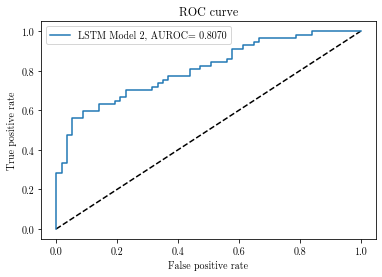

In [56]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="LSTM Model 2, AUROC= %.4f"%auroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('LSTM_M2_AUROC.png')
# plt.savefig('LSTM_M2_AUROC.eps')
plt.show()

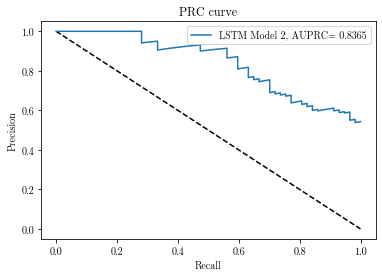

In [57]:
plt.plot([0, 1],[1, 0],  'k--')
plt.plot(recall,precision, label="LSTM Model 2, AUPRC= %.4f"%auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.savefig('LSTM_M2_AUPRC.png')
# plt.savefig('LSTM_M2_AUPRC.eps')
plt.show()